# Ataki Dedykowane

Są to ataki, które celują w konkretny algorytm i to w nim szukają słabości. Przykładem ataku dedykowanego jest zastosowanie kryptografii różnicowej na funkcji skrótu MD5. Kryptogrfia różnicowa to zgrabne manipulowanie bitami wiadomości i sprawdzanie jak one się zmnieniają w każdej rundzie algorytmu. Manipulacje te są dopasowywane do zestawu operacji, przesunięć itp. które funkcja wykonuje. Jest to sporo pracy, ale bywa ona opłcalna.

Tym atakiem ostatecznie znaleziono kolizje w MD5, a przykładem takiej kolizji są wiadomości:

In [ ]:
import hashlib
a = 0xd131dd02c5e6eec4693d9a0698aff95c2fcab58712467eab4004583eb8fb7f8955ad340609f4b30283e488832571415a085125e8f7cdc99fd91dbdf280373c5bd8823e3156348f5bae6dacd436c919c6dd53e2b487da03fd02396306d248cda0e99f33420f577ee8ce54b67080a80d1ec69821bcb6a8839396f9652b6ff72a70
b = 0xd131dd02c5e6eec4693d9a0698aff95c2fcab50712467eab4004583eb8fb7f8955ad340609f4b30283e4888325f1415a085125e8f7cdc99fd91dbd7280373c5bd8823e3156348f5bae6dacd436c919c6dd53e23487da03fd02396306d248cda0e99f33420f577ee8ce54b67080280d1ec69821bcb6a8839396f965ab6ff72a70
print(hashlib.md5(a.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())
print(hashlib.md5(b.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())

Porównajmy wiadomości [tym narzędziem.](https://text-compare.com/) W roku 2016 znalezienie kolizji w MD5 kosztowało około 0.65$.

In [ ]:
a = 0x4dc968ff0ee35c209572d4777b721587d36fa7b21bdc56b74a3dc0783e7b9518afbfa200a8284bf36e8e4b55b35f427593d849676da0d1555d8360fb5f07fea2
b = 0x4dc968ff0ee35c209572d4777b721587d36fa7b21bdc56b74a3dc0783e7b9518afbfa202a8284bf36e8e4b55b35f427593d849676da0d1d55d8360fb5f07fea2
print(hashlib.md5(a.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())
print(hashlib.md5(b.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())

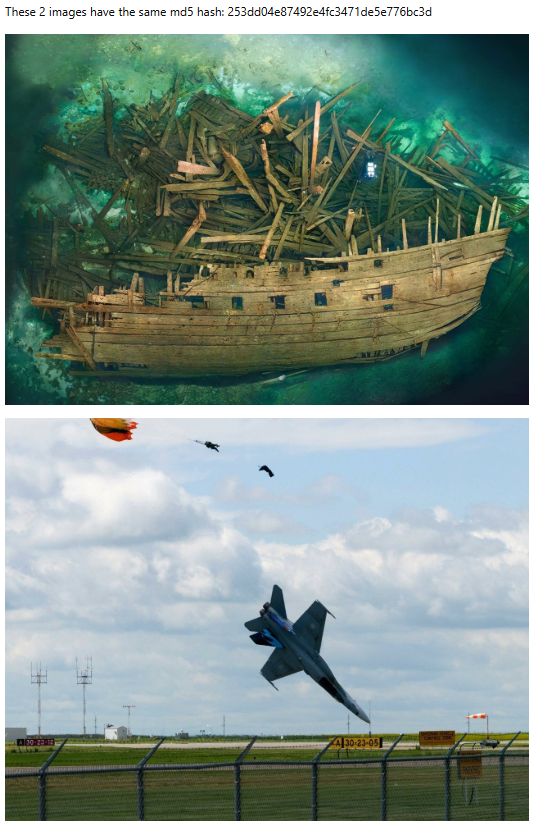

# Ataki Generyczne

Czyli ataki nie na konkretny algorytm, ale na konkretny typ algorytmu - w tym przypadku funkcję skrótu.

## Atak słownikowy
Istnieje kilka rodzajów ataków na funkcje skrótu. Najprostszym sposobem próby złamania hasza jest tzw. atak słownikowy. Polega on na tym, że mamy po prostu duży słownik danych przechowujący pary hasło - skrót. Oczywiście w takiej formie słownik będzie gigantycznym plikiem co czyni ten atak mało skutecznym. Pewnym udoskonaleniem tego ataku jest przechowywanie haseł popularnych, jak np. "admin", "123456", "abc123". Jedynym sposobem zabezpieczenia się przed słabym hasłem jest odpowiednia polityk serwisu, w którym to hasło zakładamy.

In [ ]:

# Instalacja Hashcat
!apt update
!apt install -y hashcat

In [ ]:
# Hasło, które będziemy hashować
password = "princess"

# Wygenerowanie hasha MD5
hash_md5 = hashlib.md5(password.encode()).hexdigest()
print("Hash MD5 dla hasła 'princess':", hash_md5)

In [ ]:
# Tworzenie pliku z hashem MD5 do złamania
with open("hashes.txt", "w") as f:
    f.write("8afa847f50a716e64932d995c8e7435a")

In [ ]:
# Pobranie listy słów rockyou.txt
!wget https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt

In [ ]:
!hashcat -m 0 -a 0 hashes.txt rockyou.txt --force --status  # uruchamiać bez show w razie gdy pusto pod spodem

## Tęczowe tablice
A co jeśli możemy zrobić tak, że pojedynczy wpis hasło - skrót przechowuje tak naprawdę znacznie więcej par? To są właśnie tęczowe tablice. Ogólna idea jest taka, że startujemy od jakiegoś (np. losowego) hasła. Tworzymy z niego skrót, a następnie z tego skrótu tworzymy nowe hasło z wykorzystaniem tzw. funkcji redukcji. No i powtarzamy tę czynność ustaloną liczbę razy, a na końcu do słownika dodajemy parę hasło początkowe - skrót końcowy. Stwórzmy więc krok po kroku własną tęczową tablicę i spróbujmy ją wykorzystać do złamania hasła.

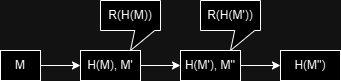

### Krok 1 - stałe

Musimy na początku ustalić kilka rzeczy, które są zależne od mocy obliczeniowej i czasu, którym dysponujemy:
1.  CHAIN_LENGTH - czyli jaka jest długość pojedynczego łancucha haszowań. Ten parametr zadecyduje ile informacji będzie przechowywał pojedynczy wpis, ale wpłynie też na szybkość obliczeń.
2. NUM_CHAINS - czyli ile wpisów będzie przechowywała nasza tęczowa tablica. Tradeoff jest oczywisty.
3. PASSWORD_LENGTH - czyli jakiej długości hasła rozważamy. Parametr ten wpływa także na funkcję redukcji,
4. CHARSET - czyli jakie znaki są w haśle w ogóle dozowlone.

Ponieważ mamy ograniczony czas, proponuję następujący zestaw parametrów:

In [ ]:
import string
CHAIN_LENGTH = 100
NUM_CHAINS = 50
PASSWORD_LENGTH = 4
CHARSET = string.digits

Załóżmy też, że będziemy łamać czterocyfrowe piny.

## Krok 2 - funkcja redukcji

Czyli funkcja, która powinna przyjąć na wejściu skrót, a na wyjściu zwrócić hasło wygenerowane w oparciu o ten skrót. Z oczywistych względów nie ma żadnej "certyfikowanej" funkcji redukcji. Nikomu nie zależy na tym (a przynajmniej nie powinno), aby efektywnie łamać hasze. Mamy tu więc dowolność. Poniżej przedstawiam moją propozycję:

In [ ]:
def reduction_function(hash_str, position):

    hash_int = #Moja propozycja: przekonwertuj hash na liczbę, dodaj pozycję w łańcuchu i oblicz modulo 10000
    return

Prosta funkcja, która tworzy ze skrótu liczbę i dodaje do tej liczby pozycję w łańcuchu, a następnie generuje określoną liczbę znaków z wybranego charsetu. Dorzucam jeszcze funkcję generującą hasło:

In [ ]:
import random
def generate_deterministic_password(index, length=PASSWORD_LENGTH):
    return #Przekonwertuj index na czterocyfrowy string (uzupełnij zerami od lewej w razie potrzeby, np. 0001).

## Krok 3 - generowanie tablicy

No to jesteśmy gotowi. Wygeneurj własną tęczową tablicę wg. opisanego niżej algorytmu:
1. Zainicjalizuj słownik rainbow_table.
2. Wykonuj kroki 3-8 NUM_CHAINS razy.
3. Wygeneruj hasło (wykorzystaj numer iteracji i funkcję generate_deterministic_password). Przypisz do zmiennej start_password.
4. Przypisz do zmiennej current_password wartość ze start_password.
5. Wykonuj kroki 6-7 CHAIN_LENGTH razy.
6. Wygeneruj hash z current_password i przypisz do current_hash.
7. Wygeneruj nowe hasło z wykorzystaniem funkcji redukcji oraz numeru iteracji pętli 5. Wykorzystaj reduction_function. Wynik przypisz do current_password.
8. Dodaj do słownika rainbow_table wartość start_password po kluczem current_hash.
10. Zwróć rainbow_table.

In [ ]:
import hashlib

def generate_rainbow_table():
  #Your code here

## Krok 4 - łamanie hasza

Mamy już wszystko czego potrzebujemy aby złamać nasz skrót. Zauważ, że każdy z naszych NUM_CHAINS wpisów musimy przeanalizować CHAIN_LENGTH razy. Czyli tak naprawdę to zredukowaliśmy rozmiar wykorzystanej pamięci kosztem wzrostu liczby obliczeń. Algorytm wyszukiwania można przedstawić następująco:

In [ ]:
def lookup_in_rainbow_table(target_hash, rainbow_table):
  #Your code here


## Krok 5 - testy

In [ ]:
rainbow_table = generate_rainbow_table()

In [ ]:
hash = hashlib.md5("9999".encode('utf-8')).hexdigest()
result = lookup_in_rainbow_table(hash, rainbow_table)
print(hash)
print(result)
print(hashlib.md5(result.encode('utf-8')).hexdigest())

Zwórć uwagę, że w miarę regularnie łamiemy 4 cyfrowy kod pin posiadając raptem 50 wpisów w naszym słowniku (!!!). A teraz wyobraź sobie, że w internecie są dostępne takie tablice o rozmiarach terabajtów. Dodaj do tego fakt, że po pierwsze potencjalny atakujący nie chce złamać konkretnie Twojego pinu. Atakującemu wystarczy po prostu złamanie jak największej liczby pinów.


Ok, czas na eksperymenty. Pobawmy się tym co mamy.

## Zadania

1. Napisz funkcję iterującą po wszystkich pinach od 0000 do 9999 i policz ile z nich udało Ci się złamać tęczową tablicą.
2. Wymyśl własną funkcję redukcji i ponownie wykonaj 1. Czy Twoja funkcja redukcji jest bardziej efektywna?
3. Spróbuj zwiększyć długość pinu i dostosować parametry tablicy.
4. Skorzystaj z certyfikowanych funkcji skrótu. Sprawdź, czy uda Ci się osiągnąć to samo.


In [ ]:
# your tests here